In [1]:
import random
import numpy as np
import torch as th
from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import DataLoader, random_split

import plotly.graph_objects as go
from utils.plots import multiviz_trajs

from models.vqvae import VQVAEAgents
from utils.load_data import get_real_dataset_num_agents
from utils.bernstein_coeff_order10_arbitinterval import get_coeffs

In [2]:
manualSeed = 999            
print("Random Seed: ", manualSeed)

random.seed(manualSeed)
th.manual_seed(manualSeed)
np.random.seed(manualSeed)
th.use_deterministic_algorithms(False)

th.set_float32_matmul_precision('high')

Random Seed:  999


In [ ]:
num         = 50
t_fin       = 5
num_agent   = 16

name        = "train_00"
batch_size  = 64

nef         = 128   # Size of feature maps in encoder
ndf         = 128   # Size of feature maps in decoder

zdim        = 3     # Size of codebook vectors in the quantizer layer
znum        = 512    # number of codebook vectors

lheight     = 3    # latent vector height
lwidth      = 3    # Latent vector width

num_epochs  = 300
device      = th.device("cuda" if th.cuda.is_available() else "cpu")

print(device)

cuda


In [4]:
P, Pdot, Pddot = get_coeffs(num, t_fin, device)
nvar = P.size(dim=-1) 

In [5]:
dataset = get_real_dataset_num_agents(P.cpu(), num_agent, nvar)
len_data = len(dataset)
len_val = batch_size # max(1, int(0.05 * len_data))

gen = th.Generator().manual_seed(42)
train_set, val_set = random_split(dataset, [len_data - len_val, len_val], gen)

val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

In [6]:
vq_model = VQVAEAgents(
    P, Pdot, Pddot, num_agent=num_agent, nvar=11, emb_num=znum, emb_dim=zdim, zdim=zdim, tdim=3, beta=0.2,
    lheight=lheight, lwidth=lwidth, nef=nef, ndf=ndf, device=device, batch=batch_size
)
cvq_model = th.compile(vq_model)

vq_model.train()
summary(vq_model, [
    (batch_size, 3, num_agent, num), 
    (batch_size, num_agent), (batch_size, num_agent), (batch_size, num_agent),
    (batch_size, num_agent), (batch_size, num_agent), (batch_size, num_agent)
])

Layer (type:depth-idx)                   Output Shape              Param #
VQVAEAgents                              [64, 3, 16, 11]           --
├─Sequential: 1-1                        [64, 4, 4, 3]             --
│    └─Conv2d: 2-1                       [64, 128, 16, 50]         71,808
│    └─BatchNorm2d: 2-2                  [64, 128, 16, 50]         256
│    └─LeakyReLU: 2-3                    [64, 128, 16, 50]         --
│    └─AdaptiveAvgPool2d: 2-4            [64, 128, 10, 40]         --
│    └─Conv2d: 2-5                       [64, 128, 10, 40]         1,982,464
│    └─BatchNorm2d: 2-6                  [64, 128, 10, 40]         256
│    └─LeakyReLU: 2-7                    [64, 128, 10, 40]         --
│    └─AdaptiveAvgPool2d: 2-8            [64, 128, 8, 30]          --
│    └─Conv2d: 2-9                       [64, 128, 8, 30]          1,622,016
│    └─BatchNorm2d: 2-10                 [64, 128, 8, 30]          256
│    └─LeakyReLU: 2-11                   [64, 128, 8, 30]       

In [7]:
(x_trajs, y_trajs, z_trajs), _  = next(iter(DataLoader(val_set, batch_size=len(val_set), shuffle=False, drop_last=True)))
trajs = th.stack([x_trajs, y_trajs, z_trajs], dim=-3).to(device=device)
_, latent_idx, *_, latent = vq_model.encode(trajs)

latent = latent.detach().cpu().numpy()
latent_idx = latent_idx.flatten().detach().cpu().numpy()

point = vq_model.quantizer.embedding.weight.detach().cpu().numpy().T
x, y, z = point
fig = go.Figure(
    data=[
        go.Scatter3d(x=latent[..., 0].ravel(), y=latent[..., 1].ravel(), z=latent[..., 2].ravel(), mode='markers', marker=dict(size=3, color=latent_idx)),
        go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(line=dict(width=2), size=3, color=np.arange(znum))),
    ],
    layout=go.Layout(width=1_000, height=500, showlegend=False)
)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()

In [8]:
optimizer = th.optim.AdamW(vq_model.parameters(), lr=1e-3, weight_decay=6e-1)
scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)

In [9]:
avg_loss, avg_len, avg_rec_loss, avg_res_loss, avg_q_loss = [], [], [], [], []

for epoch in range(num_epochs):
	
	losses, rec_losses, res_losses, q_losses, len_losses = [], [], [], [], []
	progression_bar = tqdm(train_loader, desc=f"Epoch: {epoch:>2}/{num_epochs:>2}")
	for (x_trajs, y_trajs, z_trajs), _ in progression_bar:

		trajs = th.stack([x_trajs, y_trajs, z_trajs], dim=-3).to(device=device)
		x_init, y_init, z_init = trajs[:, 0, :, 0], trajs[:, 1, :, 0], trajs[:, 2, :, 0]
		x_fin, y_fin, z_fin = trajs[:, 0, :, -1], trajs[:, 1, :, -1], trajs[:, 2, :, -1]

		rec_sol, quantizer_loss = cvq_model(trajs, x_init, y_init, z_init, x_fin, y_fin, z_fin)
		rec_trajs = rec_sol @ P.mT
		px_trajs, py_trajs, pz_trajs = rec_trajs[:, 0, :, :], rec_trajs[:, 1, :, :], rec_trajs[:, 2, :, :]

		p_trajs = th.stack([px_trajs, py_trajs, pz_trajs], dim=-3).to(device=device)
		rec_loss = th.nn.functional.mse_loss(p_trajs, trajs)
		
		len_loss = rec_trajs.diff(dim=-1).pow(2).sum(dim=-1).mean()
		loss = (1e0 * rec_loss) + quantizer_loss

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		losses.append(loss.item())
		rec_losses.append(rec_loss.item())
		q_losses.append(quantizer_loss.item())
		len_losses.append(len_loss.item())

		ep_loss, ep_l_loss, ep_rec_loss, ep_q_loss, ep_res_loss = (
			np.average(losses), np.average(len_losses), np.average(rec_losses), np.average(q_losses), 0 
		)
		progression_bar.set_postfix({
			'Loss_Train': f'{ep_loss:.4f}', 
			'Loss_Rec': f'{ep_rec_loss:.4f}',
			'Loss_Q': f'{ep_q_loss:.4f}',
			'Loss_Len': f'{ep_l_loss:.4f}'
		})

	avg_loss.append(ep_loss), avg_rec_loss.append(ep_rec_loss), avg_q_loss.append(ep_q_loss)
	avg_len.append(ep_l_loss)
	scheduler.step(ep_loss)


Epoch: 25/300:  76%|███████▌  | 25/33 [00:01<00:00, 24.08it/s, Loss_Train=0.0572, Loss_Rec=0.0338, Loss_Q=0.0235, Loss_Len=0.0460]


KeyboardInterrupt: 

In [ ]:
(nx_trajs, ny_trajs, nz_trajs), _  = next(iter(DataLoader(val_set, batch_size=len(val_set), shuffle=False, drop_last=True)))
ntrajs = th.stack([nx_trajs, ny_trajs, nz_trajs], dim=-3).to(device=device)
_, latent_idx, *_, latent = vq_model.encode(ntrajs)

latent = latent.detach().cpu().numpy()
latent_idx = latent_idx.flatten().detach().cpu().numpy()

point = vq_model.quantizer.embedding.weight.detach().cpu().numpy().T
x, y, z, *_ = point
fig = go.Figure(
    data=[
        go.Scatter3d(x=latent[..., 0].ravel(), y=latent[..., 1].ravel(), z=latent[..., 2].ravel(), mode='markers', marker=dict(size=3, color=latent_idx)),
        go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(line=dict(width=2), size=3, color=np.arange(znum))),
    ],
    layout=go.Layout(width=1_000, height=500, showlegend=False)
)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()

In [ ]:
th.save(vq_model.state_dict(), f"./resources/weights/vqvae/{name}")

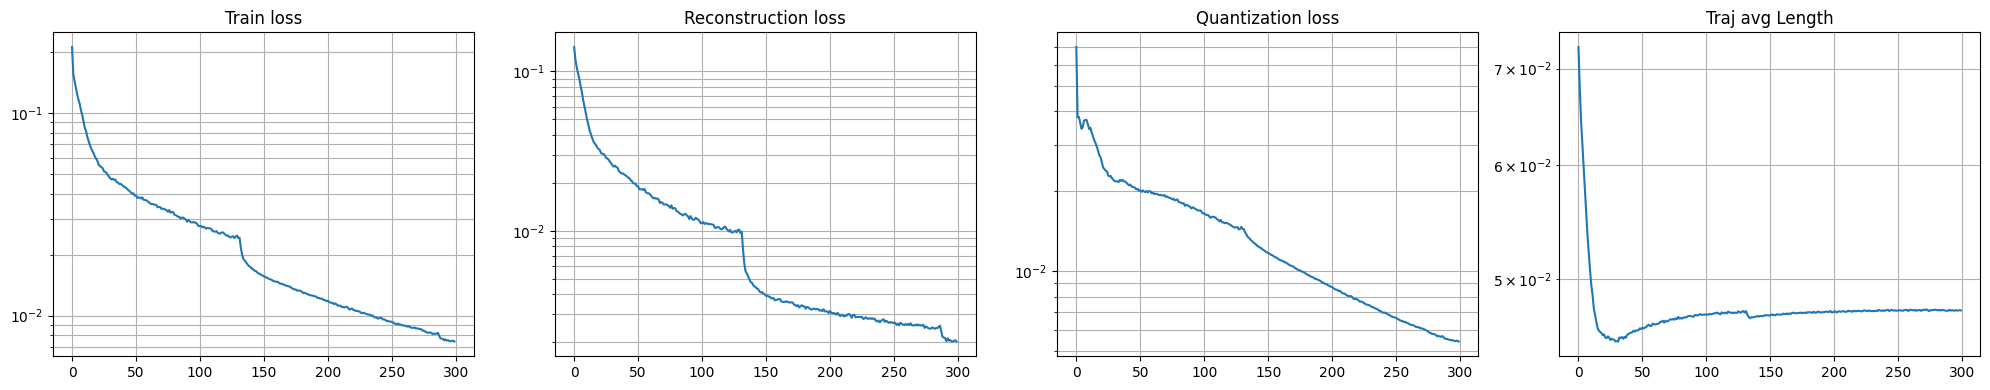

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 4))
ax = plt.subplot(141)
ax.plot(avg_loss)
ax.set_title("Train loss")
ax.set_yscale('log')
ax.grid(which="both")

ax = plt.subplot(142)
ax .plot(avg_rec_loss)
ax.set_title("Reconstruction loss")
ax.set_yscale('log')
ax.grid(which="both")

ax = plt.subplot(143)
ax.plot(avg_q_loss)
ax.set_title("Quantization loss")
ax.set_yscale('log')
ax.grid(which="both")

ax = plt.subplot(144)
ax.plot(avg_len)
ax.set_title("Traj avg Length")
ax.set_yscale('log')
ax.grid(which="both")

plt.tight_layout()
plt.show()

In [ ]:
# Ground Truth
multiviz_trajs(x_trajs[:3], y_trajs[:3], z_trajs[:3], nrows=1, ncols=3, height=400, width=1_600)

In [ ]:
# Reconstructed
npx_trajs = px_trajs.detach().cpu().numpy()
npy_trajs = py_trajs.detach().cpu().numpy()
npz_trajs = pz_trajs.detach().cpu().numpy()
multiviz_trajs(npx_trajs[:3], npy_trajs[:3], npz_trajs[:3], nrows=1, ncols=3, height=400, width=1_600)